In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import glob
import os

from keras import Input
from keras.applications import VGG19
from keras.callbacks import TensorBoard
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense
from keras.layers import Conv2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam


import random
from numpy import asarray
from itertools import repeat

import imageio
from imageio import imread
from PIL import Image
from skimage.transform import resize as imresize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

2024-02-26 22:01:56.287837: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 22:01:56.287932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 22:01:56.393862: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# batch size equals to 8 (due to RAM limits)
batch_size = 8

# define the shape of low resolution image (LR) 
low_resolution_shape = (64, 64, 3)

# define the shape of high resolution image (HR) 
high_resolution_shape = (256, 256, 3)

# optimizer for discriminator, generator 
common_optimizer = Adam(0.0002, 0.5)

# use seed for reproducible results
SEED = 2020 
tf.random.set_seed(SEED)

In [3]:
import glob
from PIL import Image

# Update the paths for your dataset
TRAIN_PATH = r'../input/sr-sat-img/train/high_res/images'
VAL_PATH = r'../input/sr-sat-img/valid/high_res/images'
TEST_PATH = r'../input/sr-sat-img/test/high_res/images'

# Set the data path to the training path initially
data_path = TRAIN_PATH

def get_train_images(data_path):
    """Retrieve paths of images in the specified directory."""
    image_paths = glob.glob(data_path + '/*')
    return image_paths

def find_img_dims(image_paths):
    """Find the minimum and maximum dimensions of images."""
    min_size = float('inf')
    max_size = 0
    
    for img_path in image_paths:
        with Image.open(img_path) as img:
            width, height = img.size
            min_size = min(min_size, min(width, height))
            max_size = max(max_size, max(width, height))
    
    return min_size, max_size

# Get image paths
train_image_paths = get_train_images(TRAIN_PATH)
val_image_paths = get_train_images(VAL_PATH)
test_image_paths = get_train_images(TEST_PATH)

# Find min/max image dimensions
min_size_train, max_size_train = find_img_dims(train_image_paths)
min_size_val, max_size_val = find_img_dims(val_image_paths)
min_size_test, max_size_test = find_img_dims(test_image_paths)

print('For training images: Min size: {}, Max size: {}'.format(min_size_train, max_size_train))
print('For validation images: Min size: {}, Max size: {}'.format(min_size_val, max_size_val))
print('For testing images: Min size: {}, Max size: {}'.format(min_size_test, max_size_test))


For training images: Min size: 512, Max size: 512
For validation images: Min size: 512, Max size: 512
For testing images: Min size: 512, Max size: 512


In [4]:
def compute_psnr(original_image, generated_image):
    
    original_image = tf.convert_to_tensor(original_image, dtype=tf.float32)
    generated_image = tf.convert_to_tensor(generated_image, dtype=tf.float32)
    psnr = tf.image.psnr(original_image, generated_image, max_val=1.0)

    return tf.math.reduce_mean(psnr, axis=None, keepdims=False, name=None)

def plot_psnr(psnr):
    
    psnr_means = psnr['psnr_quality']
    plt.figure(figsize=(10,8))
    plt.plot(psnr_means)    
    plt.xlabel('Epochs')
    plt.ylabel('PSNR') 
    plt.title('PSNR')
    
def compute_ssim(original_image, generated_image):
    
    original_image = tf.convert_to_tensor(original_image, dtype=tf.float32)
    generated_image = tf.convert_to_tensor(generated_image, dtype=tf.float32)
    ssim = tf.image.ssim(original_image, generated_image, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)

    return tf.math.reduce_mean(ssim, axis=None, keepdims=False, name=None)

def plot_ssim(ssim):
    
    ssim_means = ssim['ssim_quality']

    plt.figure(figsize=(10,8))
    plt.plot(ssim_means)
    plt.xlabel('Epochs')
    plt.ylabel('SSIM')
    plt.title('SSIM')
    
def plot_loss(losses):

    d_loss = losses['d_history']
    g_loss = losses['g_history']
    
   
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Loss")    
    plt.legend()

In [5]:
# def sample_images(image_list, batch_size, high_resolution_shape, low_resolution_shape):
    
#     """
#     Pre-process a batch of training images
#     """
    
#     # image_list is the list of all images
#     # ransom sample a batch of images
#     images_batch = np.random.choice(image_list, size=batch_size)
    
#     lr_images = []
#     hr_images = []
    

#     for img in images_batch:
  
#         img1 = imread(img, as_gray=False, pilmode='RGB')
#         #img1 = imread(img, pilmode='RGB')
#         img1 = img1.astype(np.float32)
        
#         # change the size     
#         img1_high_resolution = imresize(img1, high_resolution_shape)
#         img1_low_resolution = imresize(img1, low_resolution_shape)
                

#         # do a random horizontal flip
#         if np.random.random() < 0.5:
#             img1_high_resolution = np.fliplr(img1_high_resolution)
#             img1_low_resolution = np.fliplr(img1_low_resolution)
       
#         hr_images.append(img1_high_resolution)
#         lr_images.append(img1_low_resolution)
        
   
     # convert lists into numpy ndarrays
#     return np.array(hr_images), np.array(lr_images)  

In [6]:
from skimage.io import imread
from skimage.transform import resize

def sample_images(image_list, batch_size, high_resolution_shape, low_resolution_shape):
    """
    Pre-process a batch of training images
    """
    # Randomly sample a batch of images
    images_batch = np.random.choice(image_list, size=batch_size)
    
    lr_images = []
    hr_images = []
    
    for img in images_batch:
        img1 = imread(img, pilmode='RGB')
        img1 = img1.astype(np.float32)
        
        # Resize the images
        img1_high_resolution = resize(img1, high_resolution_shape)
        img1_low_resolution = resize(img1, low_resolution_shape)
        
        # Do a random horizontal flip
        if np.random.random() < 0.5:
            img1_high_resolution = np.fliplr(img1_high_resolution)
            img1_low_resolution = np.fliplr(img1_low_resolution)
       
        hr_images.append(img1_high_resolution)
        lr_images.append(img1_low_resolution)
        
    # Convert lists into numpy ndarrays
    return np.array(hr_images), np.array(lr_images)


In [7]:
def save_images(original_image, lr_image, sr_image, path):
    
    """
    Save LR, HR (original) and generated SR
    images in one panel 
    """
    
    fig, ax = plt.subplots(1,3, figsize=(10, 6))

    images = [original_image, lr_image, sr_image]
    titles = ['HR', 'LR','SR - generated']

    for idx,img in enumerate(images):
        # (X + 1)/2 to scale back from [-1,1] to [0,1]
        ax[idx].imshow((img + 1)/2.0, cmap='gray')
        ax[idx].axis("off")
    for idx, title in enumerate(titles):    
        ax[idx].set_title('{}'.format(title))
        
    plt.savefig(path)  

In [8]:
def residual_block(x):

    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Add()([res, x])
    
    return res

def build_generator():
    
    # use 16 residual blocks in generator
    residual_blocks = 16
    momentum = 0.8
    
    # input LR dimension: 4x downsample of HR
    input_shape = (64, 64, 3)
    
    # input for the generator
    input_layer = Input(shape=input_shape)
    
    # pre-residual block: conv layer before residual blocks 
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)
    
    # add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)
    
    # post-residual block: conv and batch-norm layer after residual blocks
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)
    
    # take the sum of pre-residual block(gen1) and post-residual block(gen2)
    gen3 = Add()([gen2, gen1])
    
    # upsampling
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)
    
    # upsampling
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)
    
    # conv layer at the output
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)
    
    # model 
    model = Model(inputs=[input_layer], outputs=[output], name='generator')

    return model

generator = build_generator()

In [9]:
def build_discriminator():
    
    # define hyperparameters
    leakyrelu_alpha = 0.2
    momentum = 0.8
    
    # the input is the HR shape
    input_shape = (256, 256, 3)
    
    # input layer for discriminator
    input_layer = Input(shape=input_shape)
    
    # 8 convolutional layers with batch normalization  
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)

    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)

    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)
    
    # fully connected layer 
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)
    
    # last fully connected layer - for classification 
    output = Dense(units=1, activation='sigmoid')(dis9)   
    
    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    
    return model

discriminator = build_discriminator()
discriminator.trainable = True
discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

In [10]:
VGG19_base = VGG19(weights="imagenet")


574710816/574710816 [==============================] - 2s 0us/step


In [11]:
# def build_VGG19():
    
#     input_shape = (256, 256, 3)
#     VGG19_base.outputs = [VGG19_base.get_layer('block5_conv2').output]
#     input_layer = Input(shape=input_shape)
#     features = VGG19_base(input_layer)
#     model = Model(inputs=[input_layer], outputs=[features])
    
#     return model

In [12]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define common optimizer
common_optimizer = Adam(0.0002, 0.5)

def build_VGG19(input_shape=(256, 256, 3)):
    # Load VGG19 without pre-trained weights and with custom input shape
    base_model = VGG19(include_top=False, weights=None, input_tensor=Input(shape=input_shape))

    # Output from a specific layer (block5_conv2)
    outputs = base_model.get_layer('block5_conv2').output

    # Create a new model with modified input shape and truncated architecture
    model = Model(inputs=base_model.input, outputs=outputs)

    return model

# Build the modified VGG19 model
fe_model = build_VGG19()

# Set the model to not trainable
fe_model.trainable = False

# Compile the model
fe_model.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])


In [13]:
def build_adversarial_model(generator, discriminator, feature_extractor):
    
    # input layer for high-resolution images
    input_high_resolution = Input(shape=high_resolution_shape)

    # input layer for low-resolution images
    input_low_resolution = Input(shape=low_resolution_shape)

    # generate high-resolution images from low-resolution images
    generated_high_resolution_images = generator(input_low_resolution)

    # extract feature maps from generated images
    features = feature_extractor(generated_high_resolution_images)
    
    # make a discriminator non-trainable 
    discriminator.trainable = False
    discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

    # discriminator will give us a probability estimation for the generated high-resolution images
    probs = discriminator(generated_high_resolution_images)

    # create and compile 
    adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
    adversarial_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=common_optimizer)
    
    return adversarial_model

adversarial_model = build_adversarial_model(generator, discriminator, fe_model)

Epoch: 0
1/1 [==============================] - 2s 2s/step


I0000 00:00:1708984980.625305      67 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch: 1
1/1 [==============================] - 0s 21ms/step
Epoch: 2
1/1 [==============================] - 0s 23ms/step
Epoch: 3
1/1 [==============================] - 0s 24ms/step
Epoch: 4
1/1 [==============================] - 0s 21ms/step
Epoch: 5
1/1 [==============================] - 0s 23ms/step
Epoch: 6
1/1 [==============================] - 0s 29ms/step
Epoch: 7
1/1 [==============================] - 0s 24ms/step
Epoch: 8
1/1 [==============================] - 0s 29ms/step
Epoch: 9
1/1 [==============================] - 0s 21ms/step
Epoch: 10
1/1 [==============================] - 0s 21ms/step
Epoch: 11
1/1 [==============================] - 0s 21ms/step
Epoch: 12
1/1 [==============================] - 0s 21ms/step
Epoch: 13
1/1 [==============================] - 0s 24ms/step
Epoch: 14
1/1 [==============================] - 0s 20ms/step
Epoch: 15
1/1 [==============================] - 0s 21ms/step
Epoch: 16
1/1 [==============================] - 0s 23ms/step
Epoch: 17
1/1 [==

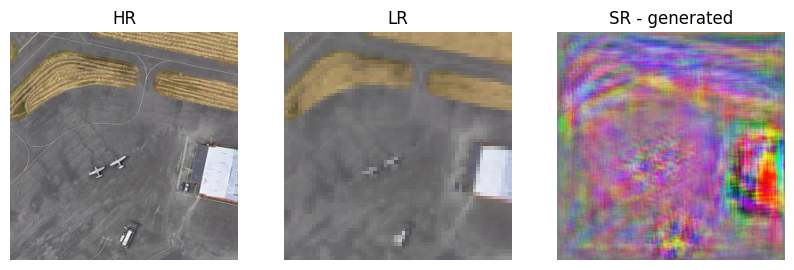

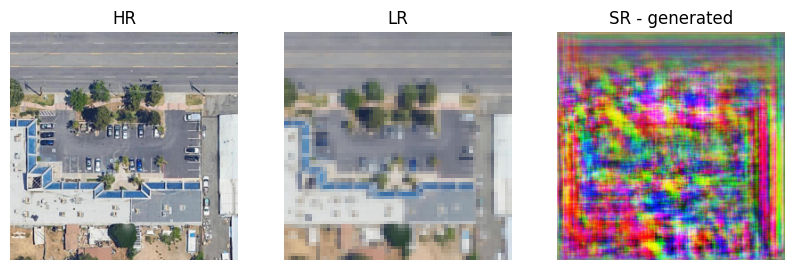

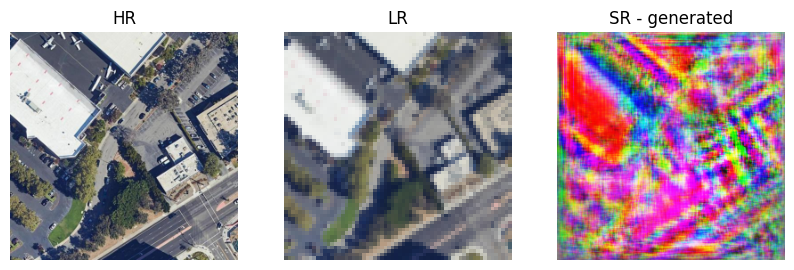

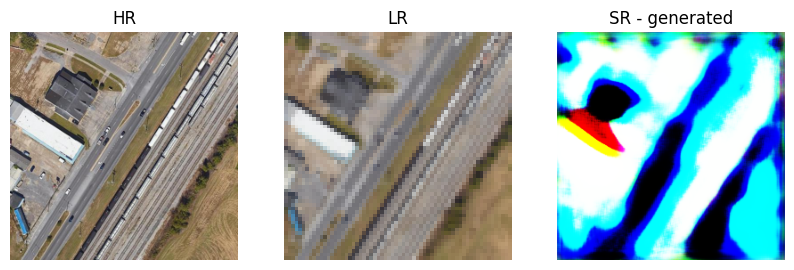

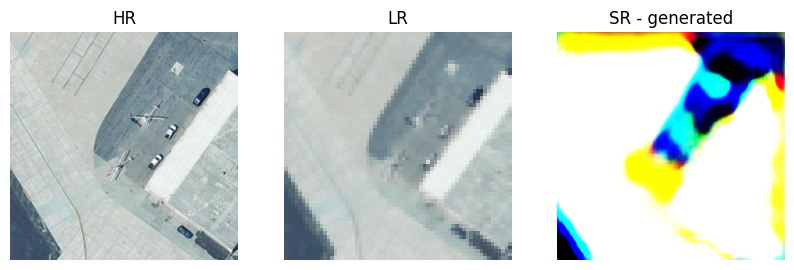

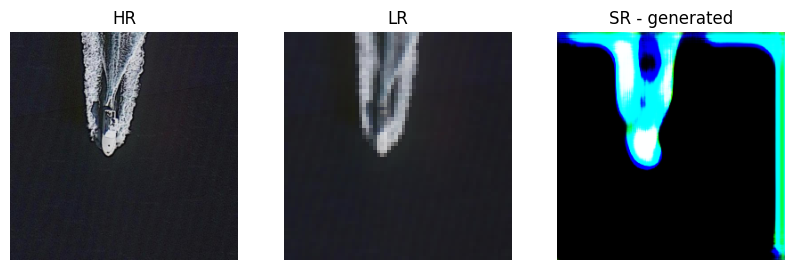

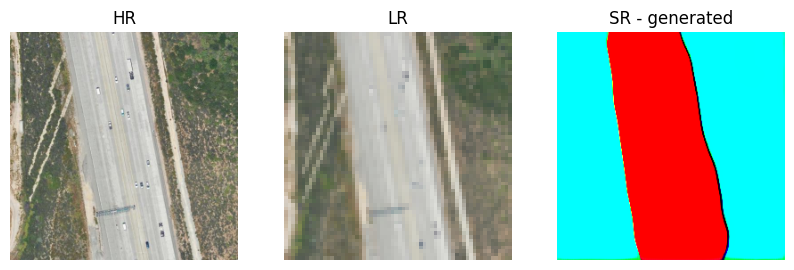

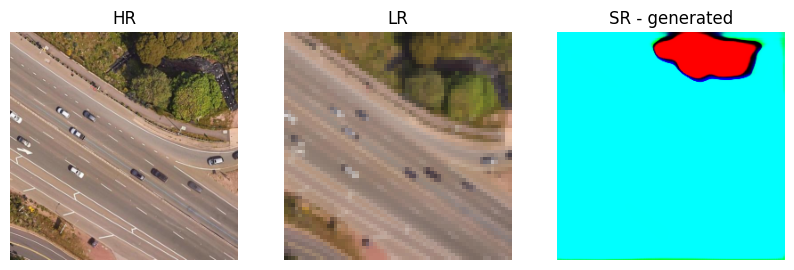

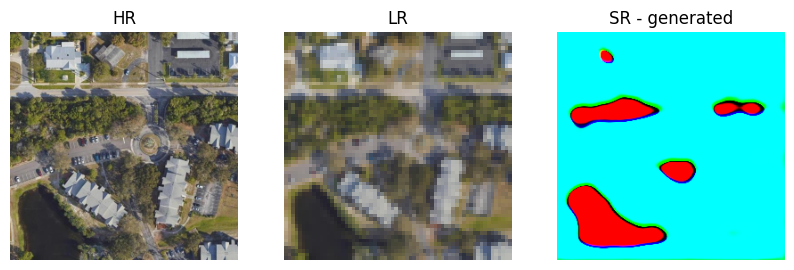

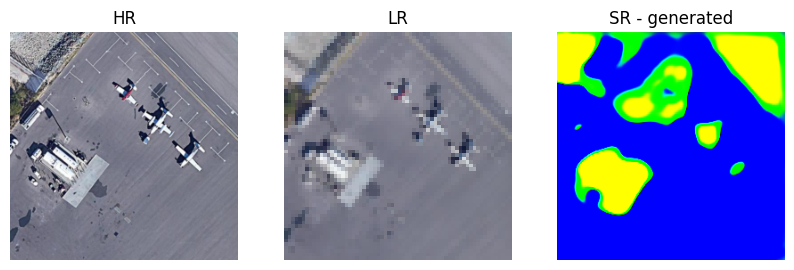

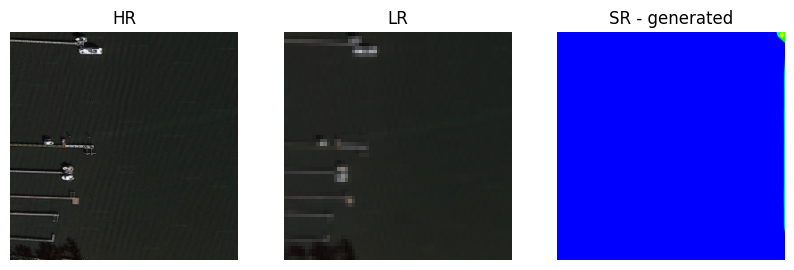

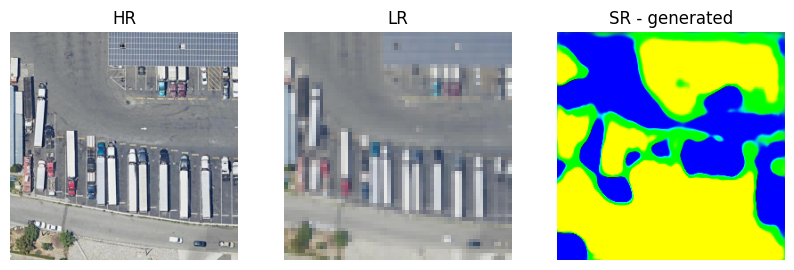

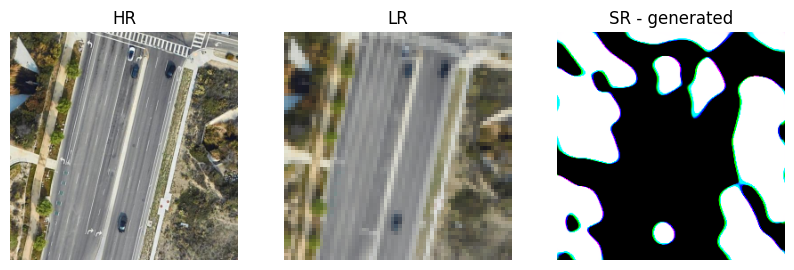

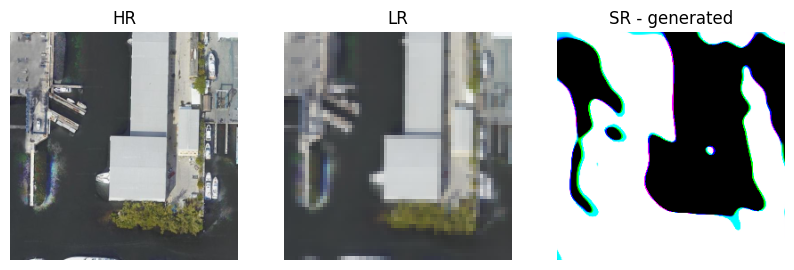

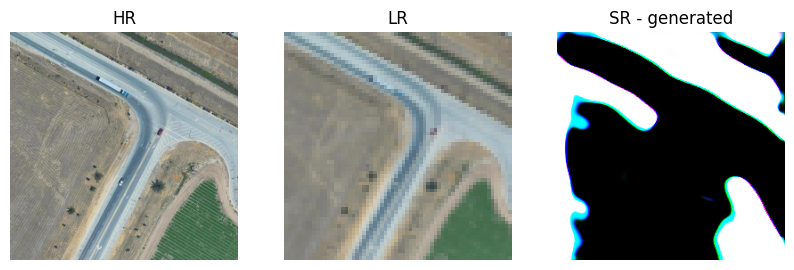

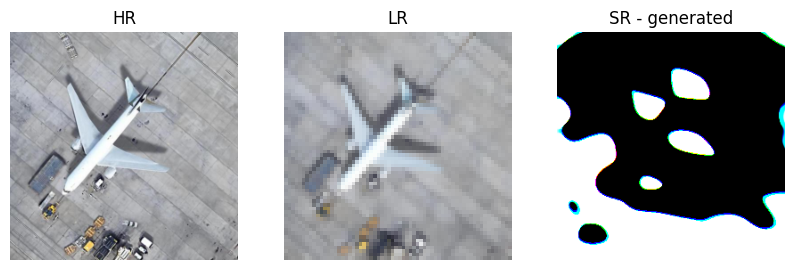

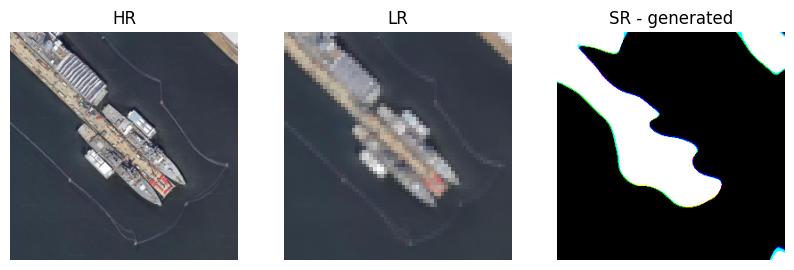

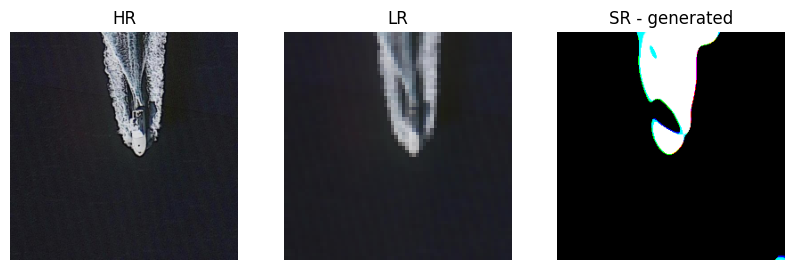

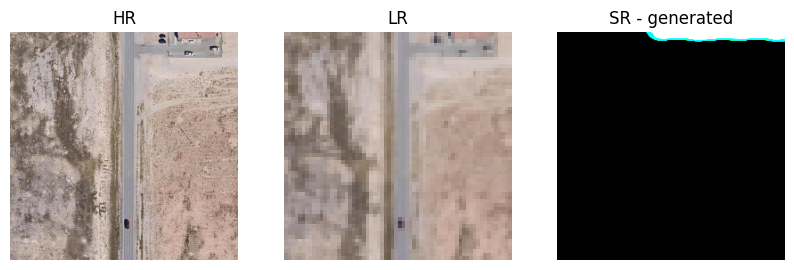

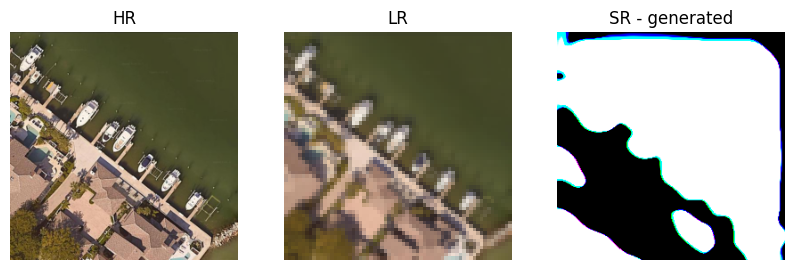

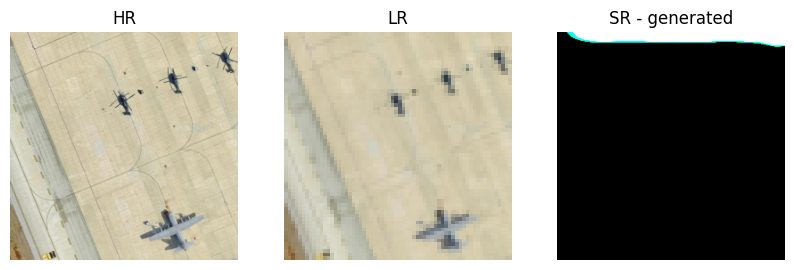

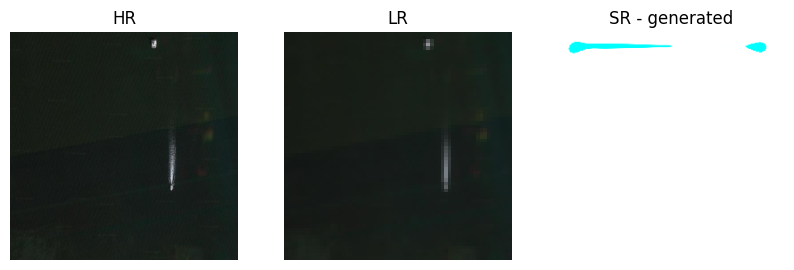

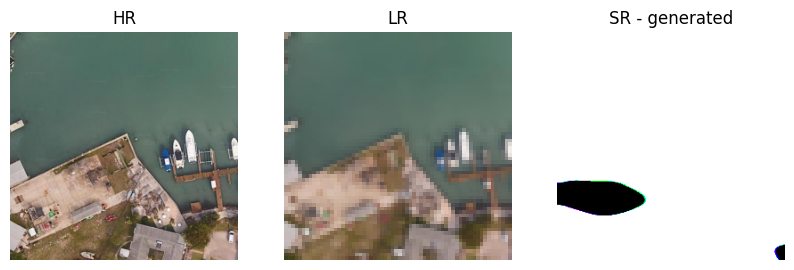

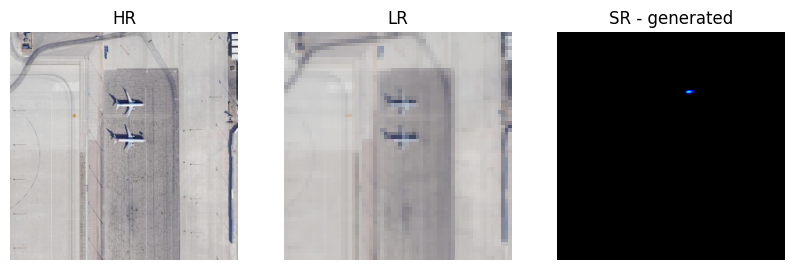

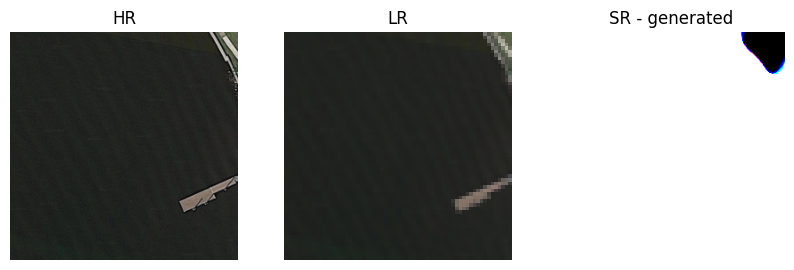

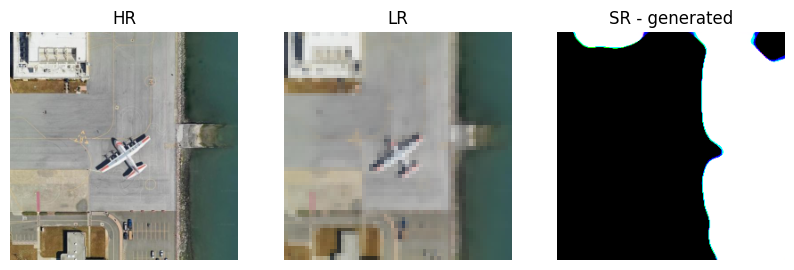

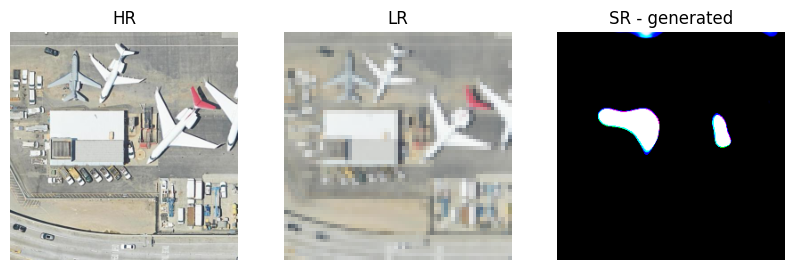

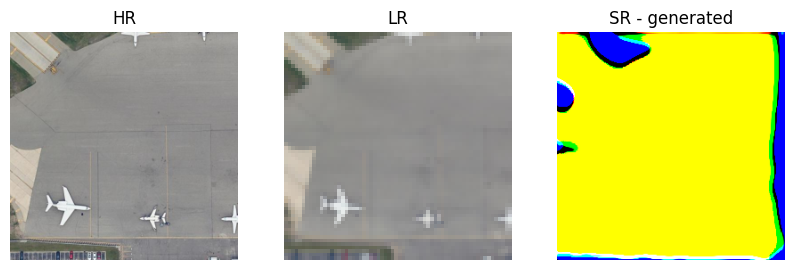

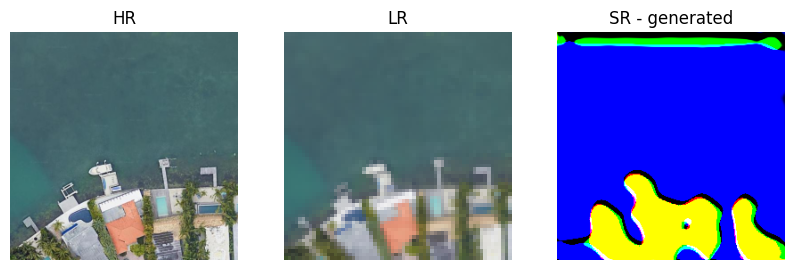

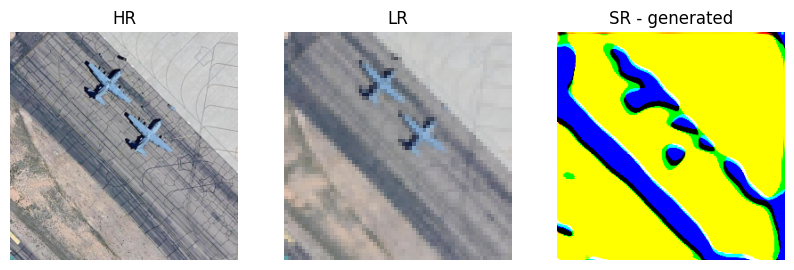

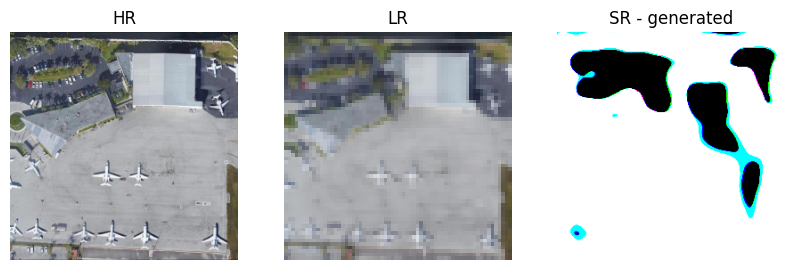

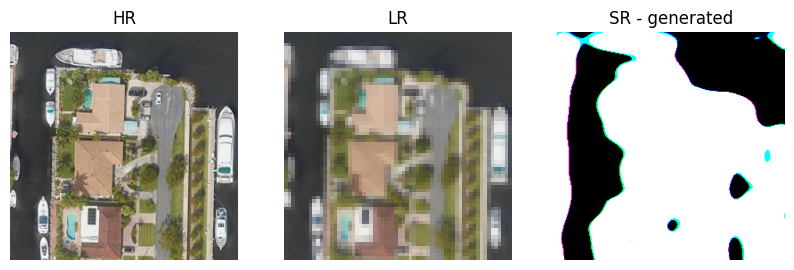

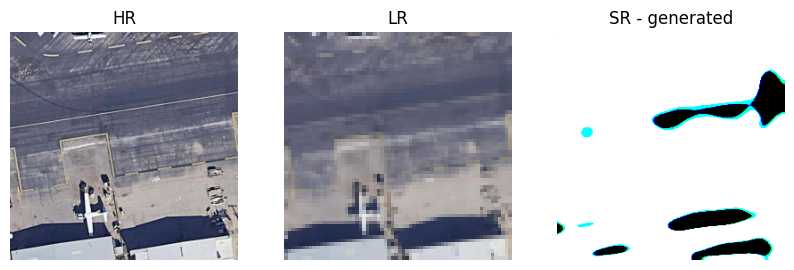

In [14]:
import numpy as np
epochs = 5001

losses = {"d_history":[], "g_history":[]}
psnr = {'psnr_quality': []}
ssim = {'ssim_quality': []}

# training loop

for epoch in range(epochs):
    print("Epoch:", epoch)  # Print the current epoch number
    
    d_history = []
    g_history = []
    
    image_list = get_train_images(data_path)
    
    """
    Train the discriminator network
    """
    
    hr_images, lr_images = sample_images(image_list, 
                                         batch_size=batch_size,
                                         low_resolution_shape=low_resolution_shape,
                                         high_resolution_shape=high_resolution_shape)
    
    # normalize the images
    hr_images = hr_images / 127.5 - 1.
    lr_images = lr_images / 127.5 - 1.
    
    # generate high-resolution images from low-resolution images
    generated_high_resolution_images = generator.predict(lr_images)
    
    # generate a batch of true and fake labels 
    real_labels = np.ones((batch_size, 16, 16, 1))
    fake_labels = np.zeros((batch_size, 16, 16, 1))
    
    d_loss_real = discriminator.train_on_batch(hr_images, real_labels)
    d_loss_real =  np.mean(d_loss_real)
    d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)
    d_loss_fake =  np.mean(d_loss_fake)
    
    # calculate total loss of discriminator as average loss on true and fake labels
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    losses['d_history'].append(d_loss)
   
    """
    Train the generator network
    """
      
    # sample a batch of images    
    hr_images, lr_images = sample_images(image_list, 
                                         batch_size=batch_size,
                                         low_resolution_shape=low_resolution_shape,
                                         high_resolution_shape=high_resolution_shape)
    
    # normalize the images
    hr_images = hr_images / 127.5 - 1.
    lr_images = lr_images / 127.5 - 1.
    
    # extract feature maps for true high-resolution images
    image_features = fe_model.predict(hr_images)
    
    # train the generator
    g_loss = adversarial_model.train_on_batch([lr_images, hr_images],
                                               [real_labels, image_features])
    
    losses['g_history'].append(0.5 * (g_loss[1]))
    
    # calculate the psnr  
    ps = compute_psnr(hr_images, generated_high_resolution_images) 
    psnr['psnr_quality'].append(ps)
            
    # calculate the ssim 
    ss = compute_ssim(hr_images, generated_high_resolution_images)   
    ssim['ssim_quality'].append(ss)
    
    """
    Save and print image samples
    """
    if epoch % 500 == 0:
        hr_images, lr_images = sample_images(image_list, 
                                             batch_size=batch_size,
                                             low_resolution_shape=low_resolution_shape,
                                             high_resolution_shape=high_resolution_shape)
    
        # normalize the images
        hr_images = hr_images / 127.5 - 1.
        lr_images = lr_images / 127.5 - 1.
    
        generated_images = generator.predict_on_batch(lr_images)
    
        for index, img in enumerate(generated_images):
            if index < 3:   # comment this line to display all the images
                save_images(hr_images[index], lr_images[index], img,
                            path="/kaggle/working/img_{}_{}".format(epoch, index))  


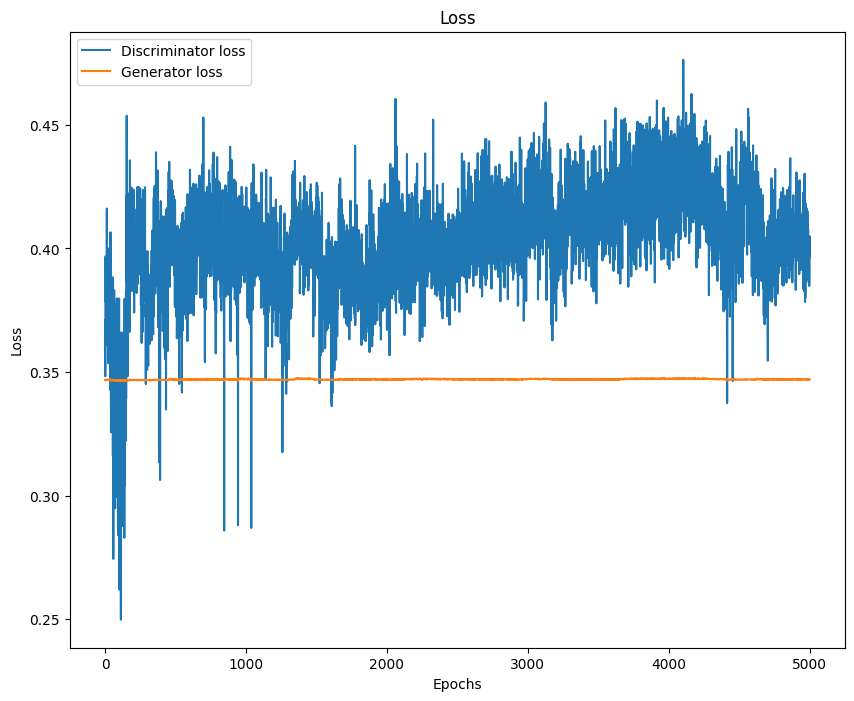

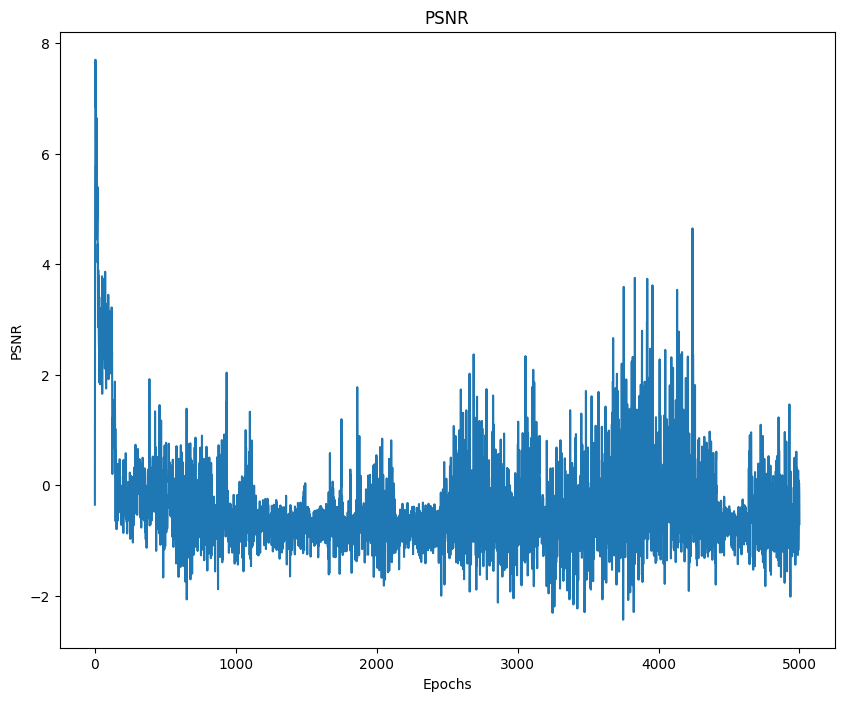

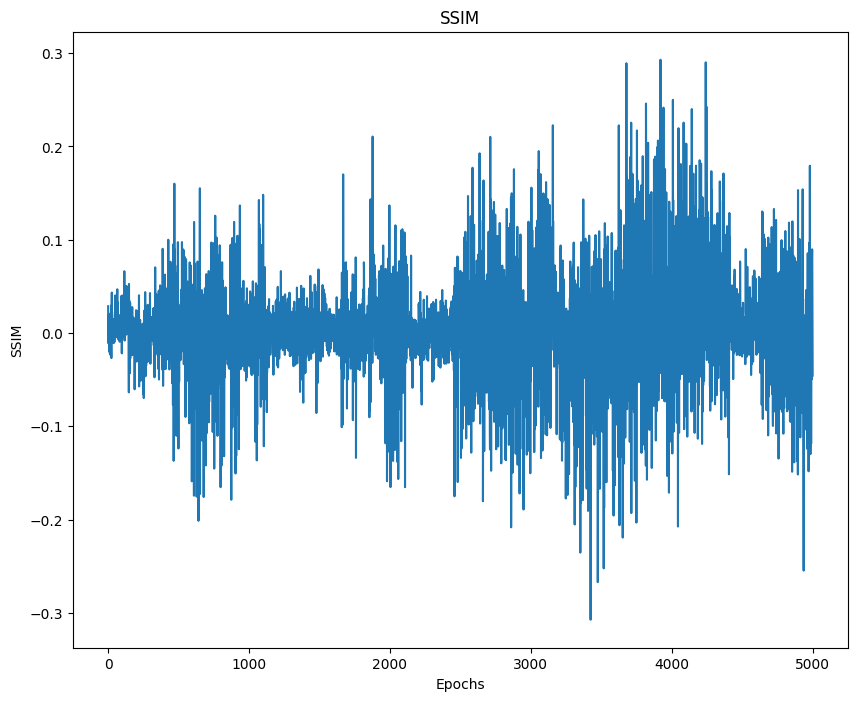

In [15]:
plot_loss(losses)
plot_psnr(psnr)
plot_ssim(ssim)